# Solubility prediction
This sample code demonstrates how to use kGCN (python module) for a toy chemical single task prediction problem in Google Colaboratory.

## Installation
It's going to take a while for constructing an environment.
### Install Anaconda

In [0]:
%%capture
!wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')
! conda update -y --all

### Install kGCN and additional requirements
- kGCN: https://github.com/clinfo/kGCN  
- RDKit: https://github.com/rdkit/rdkit
- oddt: https://github.com/oddt/oddt
- mendeleev: https://github.com/lmmentel/mendeleev

In [0]:
%%capture
! conda install -y -c rdkit rdkit
! conda install -y -c oddt oddt
! conda install -y -c lmmentel mendeleev
! conda install -y tensorflow-gpu=1.12

! conda install -y msgpack-python
! pip install git+https://github.com/clinfo/kGCN.git

### Import libraries

In [3]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from sklearn.utils import class_weight
from scipy.sparse import csr_matrix
import tensorflow as tf
import tensorflow.contrib.keras as K

import kgcn
import kgcn.data_util
import kgcn.core
import kgcn.layers
from kgcn.data_util import dense_to_sparse
from kgcn.preprocessing import chem
from kgcn.preprocessing.utils import create_adjancy_matrix, create_feature_matrix
from kgcn.default_model import DefaultModel
from kgcn.gcn import get_default_config

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## Preparation of the dataset
This sample code uses 30 molecules with solubility information.  
- smiles: list of the molecules.
- labels: list of the one-hot labels of solubility. (e.g. [high solubility, low solubility])

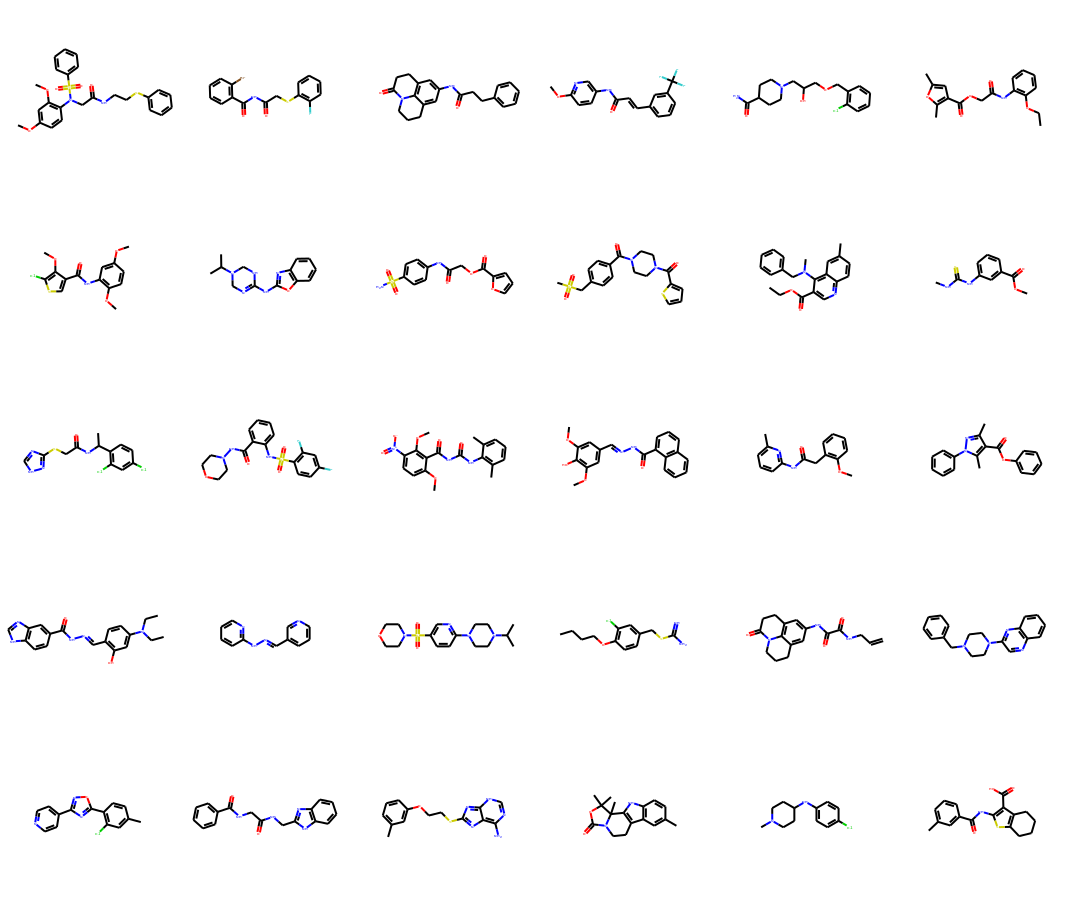

In [4]:
labels = [[0,1],[1,0], [1,0], [0,1], [1,0], [0,1], [0,1], [0,1], [1,0], [1,0], [0,1], [1,0], [1,0], [1,0], [0,1],
          [0,1], [1,0], [0,1], [0,1],[1,0], [1,0], [1,0], [1,0], [1,0], [0,1], [1,0], [0,1], [1,0], [1,0], [0,1]]
smiles = ['COC1=CC(OC)=C(C=C1)N(CC(=O)NCCSC1=CC=CC=C1)S(=O)(=O)C1=CC=CC=C1',
          'FC1=C(SCC(=O)NC(=O)C2=C(Br)C=CC=C2)C=CC=C1',
          'O=C(CCC1=CC=CC=C1)NC1=CC2=C3N(CCCC3=C1)C(=O)CC2',
          'COC1=NC=C(NC(=O)\C=C\C2=CC=CC(=C2)C(F)(F)F)C=C1',
          'NC(=O)C1CCN(CC(O)COCC2=C(Cl)C=CC=C2)CC1',
          'CCOC1=C(NC(=O)COC(=O)C2=C(C)OC(C)=C2)C=CC=C1',
          'COC1=C(Cl)SC=C1C(=O)NC1=C(OC)C=CC(OC)=C1',
          'CC(C)N1CNC(NC2=NC3=C(O2)C=CC=C3)=NC1',
          'NS(=O)(=O)C1=CC=C(NC(=O)COC(=O)C2=CC=CO2)C=C1',
          'CS(=O)(=O)CC1=CC=C(C=C1)C(=O)N1CCN(CC1)C(=O)C1=CC=CS1',
          'CCOC(=O)C1=CN=C2C=CC(C)=CC2=C1N(C)CC1=CC=CC=C1',
          'CNC(=S)NC1=CC=CC(=C1)C(=O)OC',
          'CC(NC(=O)CSC1=NNC=N1)C1=C(Cl)C=C(Cl)C=C1',
          'FC1=CC(F)=C(C=C1)S(=O)(=O)NC1=CC=CC=C1C(=O)NN1CCOCC1',
          'COC1=CC=C(C(OC)=C1C(=O)NC(=O)NC1=C(C)C=CC=C1C)[N+]([O-])=O',
          r'COC1=CC(\C=N\NC(=O)C2=CC=CC3=C2C=CC=C3)=CC(OC)=C1O',
          'COC1=C(CC(=O)NC2=NC(C)=CC=C2)C=CC=C1',
          'CC1=NN(C(C)=C1C(=O)OC1=CC=CC=C1)C1=CC=CC=C1',
          r'CCN(CC)C1=CC(O)=C(\C=N\NC(=O)C2=CC3=C(NC=N3)C=C2)C=C1',
          r'N(\N=C\C1=CC=CN=C1)C1=NC=CC=C1',
          'CC(C)N1CCN(CC1)C1=NC=C(C=C1)S(=O)(=O)N1CCOCC1',
          'CCCCOC1=C(Cl)C=C(CSC(N)=N)C=C1',
          'C=CCNC(=O)C(=O)NC1=CC2=C3N(CCCC3=C1)C(=O)CC2',
          'C(N1CCN(CC1)C1=NC2=C(C=CC=C2)N=C1)C1=CC=CC=C1',
          'CC1=CC(Cl)=C(C=C1)C1=NC(=NO1)C1=CC=NC=C1',
          'O=C(CNC(=O)C1=CC=CC=C1)NCC1=NC2=C(N1)C=CC=C2',
          'CC1=CC=CC(OCCSC2=NC3=C(N)N=CNC3=N2)=C1',
          'CC1=CC2=C(NC3=C2CCN2C(=O)OC(C)(C)C32C)C=C1',
          'CN1CCC(CC1)NC1=CC=C(Cl)C=C1',
          'CC1=CC=CC(=C1)C(=O)NC1=C(C(O)=O)C2=C(CCCC2)S1']
mol_obj_list = [Chem.MolFromSmiles(s) for s in smiles]
labels = np.array(labels, dtype=np.float16)
Draw.MolsToGridImage(mol_obj_list, molsPerRow=6, subImgSize=(180, 180))

### Constructing a dataset by converting the smiles strings.
To use graph convolutional network, the adjacency matrix and labels should be computed from the smiles strings and labels.  
In this example code, to match shapes of the graphs, you must specify a maximum number of atoms in a molecule. (this sample uses atom_num_limit = 50)

In [0]:
mask_labels = np.zeros_like(labels, dtype=np.float16)
atom_num_limit = 50

mol_list = []
adj_list = []
feature_list = []
mol_name_list = []
label_data_list = []
label_mask_list = []

for i, mol in enumerate(mol_obj_list):
    Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ADJUSTHS)
    mol_list.append(mol)
    name = f"index_{str(i)}"
    mol_name_list.append(name)
    adj = create_adjancy_matrix(mol)
    feature = create_feature_matrix(mol, atom_num_limit)

    adj_list.append(dense_to_sparse(adj))
    feature_list.append(feature)
    label_data_list.append(labels[i])
    label_mask_list.append(mask_labels[i])
    # compute class weight
    label_int = np.argmax(label_data_list, axis=1)
    cw = class_weight.compute_class_weight("balanced", np.unique(label_int), label_int)

# This dictionary is used as an input of kGCN
obj = {"feature": np.asarray(feature_list),
       "adj": np.asarray(adj_list),
       "label": np.asarray(label_data_list),
       "mask_label": np.asarray(label_mask_list),
       "label_dim": labels.shape[1],
       "label_sparse": csr_matrix(np.asarray(label_data_list).astype(float)),
       "mask_label_sparse": csr_matrix(np.asarray(label_mask_list).astype(float)),
       "max_node_num": atom_num_limit,
       "mol_info": {"obj_list": mol_list,
                    "name_list": mol_name_list},
       "class_weight": cw
       }

## Defining a neural network with graph convolution
kGCN provides `kgcn.layers` module to construct graph convolutional networks. 
- `kgcn.layers.GraphConv`: a convolution operation.
- `kgcn.layers.GraphBatchNormalization`: a batch normalization operation for graph.
- `kgcn.layers.GraphDense`: a dense operation for graph.
- `kgcn.layers.GraphGather`: a graph gather operation. 

Operators in this module are compatible with Keras library, which provides a high-level interface on Tensorflow.  
In kGCN, uses should define one neural network class (NNModel) with two methods: `build_placeholders` and `build_model`. 


In [0]:
class NNModel(DefaultModel):
    def build_placeholders(self, info, config, batch_size, **kwargs):
        # input data types (placeholders) of this neural network
        return self.get_placeholders(info, config, batch_size,
            ['adjs','nodes','labels','mask','dropout_rate',
            'enabled_node_nums','is_train','features'], **kwargs)

    def build_model(self, placeholders, info, config, batch_size, **kwargs):
        adj_channel_num = info.adj_channel_num
        embedding_dim = config["embedding_dim"]
        in_adjs = placeholders["adjs"]
        features = placeholders["features"]
        in_nodes = placeholders["nodes"]
        labels = placeholders["labels"]
        mask=placeholders["mask"]
        enabled_node_nums = placeholders["enabled_node_nums"]
        dropout_rate = placeholders["dropout_rate"]

        layer = features
        in_dim = info.feature_dim
        # layer: batch_size x graph_node_num x dim
        # 1
        layer = kgcn.layers.GraphConv(
            128,
            adj_channel_num
            )(layer, adj=in_adjs)
        layer = kgcn.layers.GraphBatchNormalization()(
            layer,
            max_node_num=info.graph_node_num,
            enabled_node_nums=enabled_node_nums
            )
        layer = tf.nn.relu(layer)
        layer = K.layers.Dropout(dropout_rate)(layer)
        # 2
        layer = kgcn.layers.GraphDense(128)(layer)
        layer = kgcn.layers.GraphBatchNormalization()(
            layer,
            max_node_num=info.graph_node_num,
            enabled_node_nums=enabled_node_nums
            )
        layer = kgcn.layers.GraphGather()(layer)
        layer = tf.nn.tanh(layer)
        # 3
        layer = K.layers.Dense(128)(layer)
        layer = K.layers.BatchNormalization()(layer)
        layer = tf.nn.relu(layer)
        logits=K.layers.Dense(info.label_dim)(layer)
        # compute prediction
        predictions = tf.nn.softmax(logits)
        # compute loss
        labels = tf.cast(labels,dtype=tf.float32)
        cw = info['class_weight']
        w = tf.reduce_sum(cw * labels, axis=1)
        unweighted_cost = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=logits)
        weighted_cost = unweighted_cost * w
        loss_to_minimize = tf.reduce_sum(weighted_cost)
        # compute correct count
        metrics = {}
        correct_count = mask*tf.cast(tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1)),tf.float32)
        metrics["correct_count"] = tf.reduce_sum(correct_count)
        return logits, predictions, loss_to_minimize, loss_to_minimize, metrics

### Loading the dataset using utilities in kGCN
kGCN provides preprocessing for graph convolution. Users can specify configuration as an argument. Please see kGCN github page (https://github.com/clinfo/kGCN) for this configuration.

In [7]:
config = {
    "with_feature": True,
    "with_node_embedding": False,
    "normalize_adj_flag":True,
    "split_adj_flag":False,
    "shuffle_data":False
}
train_data, info = kgcn.data_util.build_data(config, obj)

[OK] checking #graphs
The number of graphs                   =30
Dimension of a feature                 =81
The maximum number of nodes in a graph =50
The number of nodes in all graphs      =None
Dimension of a label                   =2
The number of adj. matrices in a graph =1



### Launching Tensorflow session to construct an actual model by instantiating NNModel

In [8]:
sess=tf.Session()
config = {
    "learning_rate": 0.01,
    "batch_size": 100,
    "param": None,
    "retrain": None,
    "save_model_path": "model",
    "epoch": 5,
    "profile": None,
    "dropout_rate": 0.,
    "task": "classification",
    "save_interval": 2,
    "embedding_dim": 4
}
model = kgcn.core.CoreModel(sess, config, info)
nn = NNModel()
model.build(nn)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.






### Training the neural network
Let's start training. Like many machine learning libraries, kGCN also starts parameter training by one line

In [9]:
model.fit(train_data)



#train data =  30


INFO:tensorflow:model/model.00000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
epoch 0, training cost 0.812432 (acc=0.566667), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00000.ckpt) 
[SAVE]  model/model.best.ckpt
INFO:tensorflow:model/model.best.ckpt is not in all_model_checkpoint_paths. Manually adding it.
epoch 1, training cost 2.93244 (acc=0.433333), validation cost 0 (acc=0) (count=0) 
INFO:tensorflow:model/model.00002.ckpt is not in all_model_checkpoint_paths. Manually adding it.
epoch 2, training cost 2.46899 (acc=0.566667), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00002.ckpt) 
epoch 3, training cost 1.0284 (acc=0.566667), validation cost 0 (acc=0) (count=0) 
INFO:tensorflow:model/model.00004.ckpt is not in all_model_checkpoint_paths. Manually adding it.
epoch 4, training cost 1.04771 (acc=0.433333), validation cost 0 (acc=0) (count=0) ([SAVE] model/model.00004.ckpt) 
[RESTORE]  model/model.best.ckpt
INFO:tensorf

### Prediction

In [10]:
train_y=model.pred(train_data)
print(train_y)


[array([0.00102312, 0.99897695], dtype=float32), array([6.1399245e-04, 9.9938595e-01], dtype=float32), array([0.00508392, 0.9949161 ], dtype=float32), array([4.3136618e-04, 9.9956864e-01], dtype=float32), array([0.02319864, 0.9768014 ], dtype=float32), array([9.778570e-04, 9.990221e-01], dtype=float32), array([6.0208864e-04, 9.9939787e-01], dtype=float32), array([0.0033563, 0.9966438], dtype=float32), array([5.3548143e-04, 9.9946457e-01], dtype=float32), array([0.00253276, 0.9974673 ], dtype=float32), array([0.00101532, 0.99898463], dtype=float32), array([0.00111334, 0.99888664], dtype=float32), array([0.00123434, 0.9987657 ], dtype=float32), array([0.00286512, 0.9971349 ], dtype=float32), array([6.4177078e-04, 9.9935824e-01], dtype=float32), array([4.2581654e-04, 9.9957412e-01], dtype=float32), array([7.7317236e-04, 9.9922681e-01], dtype=float32), array([5.1417062e-04, 9.9948585e-01], dtype=float32), array([0.0012676, 0.9987324], dtype=float32), array([7.671323e-04, 9.992329e-01], dty